In [1]:
import sys, os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools','meshing_ats','meshing_ats'))
import meshing_ats
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [2]:
#fname = '/Users/ajc/Desktop/ATS/meshes/SubgridModel/watershed/SPRUCE/2cm-resolution/SPRUCE_20_MAY_2017_DEM_2cm.vtk'
#infile = '/Users/ajc/Desktop/ATS/meshes/SubgridModel/watershed/SPRUCE/coarse/spruce-6-may-2017-dem-2cm-coarse.vtk'


#infile ="four-polygons/four_polygon-surface.vtk".encode('utf8')
#outfile = "/meshes/four-polygons/"

infile = "vtks/single_column.vtk".encode('utf8')
outfile = "/meshes/single-column/"
#m2 = meshing_ats.Mesh2D.read_VTK(fname)
m2 =meshing_ats.Mesh2D.read_VTK_Unstructured(infile)


In [3]:
#Changing organic layer thickness 
def org_layer_bottom_bndry(polygon, id):
    if (polygon == 'HCP' and id % 2 == 0):
        thickness = 0.1 
    elif(polygon == 'HCP'):
        thickness = 0.06 
    elif (polygon == 'LCP' and id %3 == 0):
        thickness = 0.2
    else:
        thickness = 0.16
    return thickness

def org_layer_bottom_bndry_gids(id):
    if id in hcp_gids:
        thickness = 0.1
    else:
        thickness= 0.20
        
    return thickness

def irz_layer_bottom_bndry_gids(id):
    if id in hcp_gids:
        thickness = 0.1
    else:
        thickness= 0.0
        
    return thickness

def org_layer_bottom_bndry_pd(pd):
    pd = pd[0] * 100;
    #print pd
    if pd < 0.5:
        thickness = 8.
    elif (pd > 5.):
        thickness = 20
    elif (pd >=0.5 and pd<=5.0):
        m = (20. - 8.)/(5.- 0.5)
        y = 8. + m*(pd - 0.5)
        thickness = np.floor(y) - np.floor(y)%2
    return thickness/100.

In [4]:
#Ids = read_poly_ids()
#ponded_depth = get_ponded_depth()
hcp_gids = [-1]
gid_based = True

peat_thickness = np.zeros(m2.num_cells())
irz_thickness = np.zeros(m2.num_cells())
if gid_based == True:
    for i in range(m2.num_cells()):
        if i in hcp_gids:
            peat_thickness[i] = org_layer_bottom_bndry_gids(i)
            irz_thickness[i] = irz_layer_bottom_bndry_gids(i)
        else:
            peat_thickness[i] = org_layer_bottom_bndry_gids(i)
            irz_thickness[i] = irz_layer_bottom_bndry_gids(i)
else:
    for i in range(m2.num_cells()):
        peat_thickness[i] = org_layer_bottom_bndry_pd(ponded_depth[i])
        print (i, peat_thickness[i], ponded_depth[i]*100)

#print (peat_thickness)

In [ ]:
m2.plot(color=['b','r','g','m','c'])
plt.show()

# Ice rich zone 40 cm
#variable peat thickness
# layer extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []


z=0
Z = []
var_layer_cells = 10
for i in range(var_layer_cells):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(-10000*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02, 6)
    Z.append(z)
print ('Peat ', z)

for i in range(10): #8cm peat, n=20, 20cm peat n = 14
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02, 6)
    Z.append(z)
print ('Upper mineral 1: ', z, Z[-1])

dz = .02 #keep the top 60 cm to 2cm resolution
for i in range(10):
    layer_types.append("constant")
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02,6)
    Z.append(z)
print ('Upper mineral 2: ', z, Z[-1])

dz = .02
for i in range(29):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
    z = round(z + dz,6)
    Z.append(z)
print ('Ice rich', z, Z[-1])

for i in range(21):
    dz *= 1.18
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
    z = round(z + dz,6)
    Z.append(z)
print (z, Z[-1])


layer_types.append('snapped')
layer_data.append(-45.0) # bottom location
layer_ncells.append(1)
layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))


mat_ids=np.zeros((m2.num_cells(), var_layer_cells), 'i')


for i in range(m2.num_cells()):
    for j in range(var_layer_cells):
        if j == 0 :
            mat_ids[i,j]=1001
        elif (Z[j] <= peat_thickness[i]):
            #print (i,j,Z[j],peat_thickness[i])
            mat_ids[i,j]=1002
        else:
            mat_ids[i,j]=1003
    
for j in range(var_layer_cells):
    layer_mat_ids[j] = mat_ids[:,j]

print ('HERE ',len(layer_mat_ids), len(layer_ncells), len(layer_types), len(layer_data))
#print (Z)
print (layer_mat_ids[13])

m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)

#m3.write_exodus('four_polygon_5layer-icerich40cm-2hcp-2lcp.exo'.encode('utf8'))

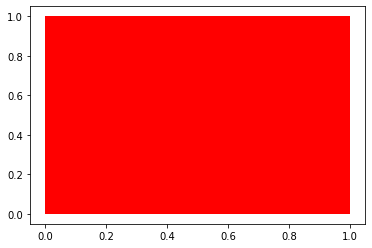

Peat  0.2
Upper mineral 1:  0.4 0.4
Upper mineral 2:  0.6 0.6
Ice rich 2.64799 2.64799
36.095143 36.095143
HERE  81 81 81 81
[array([1001], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1002], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1003], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array([1004], dtype=int32), array(

In [5]:
m2.plot(color=['b','r','g','m','c'])
plt.show()

# Ice rich zone 40 cm for LCP, and 50 cm for HCP
#variable peat thickness
# layer extrusion
layer_types = []
layer_data = []
layer_ncells = []
layer_mat_ids = []

z=0
Z = []
var_layer_cells = 10

for i in range(var_layer_cells):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(-10000*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02, 6)
    Z.append(z)
print ('Peat ', z)

for i in range(10):
    layer_types.append('constant')
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02, 6)
    Z.append(z)
print ('Upper mineral 1: ', z, Z[-1])

dz = .02 #keep the top 60 cm to 2cm resolution
for i in range(10):
    layer_types.append("constant")
    layer_data.append(0.02)
    layer_ncells.append(1)
    layer_mat_ids.append(-1004*np.ones((m2.num_cells(),),'i'))
    z = round(z + 0.02,6)
    Z.append(z)
print ('Upper mineral 2: ', z, Z[-1])

dz = .02
for i in range(29):
    dz *= 1.075
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
    z = round(z + dz,6)
    Z.append(z)
print ('Ice rich', z, Z[-1])

for i in range(21):
    dz *= 1.18
    layer_types.append("constant")
    layer_data.append(dz)
    layer_ncells.append(1)
    layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
    z = round(z + dz,6)
    Z.append(z)
print (z, Z[-1])


layer_types.append('snapped')
layer_data.append(-45.0) # bottom location
layer_ncells.append(1)
layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))

#---------------------------------------------------------------
# Assign variable peat layers
mat_ids=np.zeros((m2.num_cells(), var_layer_cells), 'i')
for i in range(m2.num_cells()):
    for j in range(var_layer_cells):
        if j == 0 :
            mat_ids[i,j]=1001
        elif (Z[j] <= peat_thickness[i]):
            #print (i,j,Z[j],peat_thickness[i])
            mat_ids[i,j]=1002
        else:
            mat_ids[i,j]=1003
    
for j in range(var_layer_cells):
    layer_mat_ids[j] = mat_ids[:,j]
#---------------------------------------------------------------


#---------------------------------------------------------------
# Assign variable ice rich zone layers
mat_ids=np.zeros((m2.num_cells(), var_layer_cells), 'i')
for i in range(m2.num_cells()):
    for j in range(var_layer_cells):
        if (Z[j] <= irz_thickness[i]):
            #print (i,j,Z[j],peat_thickness[i])
            mat_ids[i,j]=1003
        else:
            mat_ids[i,j]=1004
    
for j in range(20,20+var_layer_cells):
    layer_mat_ids[j] = mat_ids[:,j-20]
#---------------------------------------------------------------



print ('HERE ',len(layer_mat_ids), len(layer_ncells), len(layer_types), len(layer_data))
#print (Z)
print (layer_mat_ids)

m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                        layer_data, 
                                        layer_ncells, 
                                        layer_mat_ids)

#m3.write_exodus('four_polygons_5layer-icerich40cm-2hcp-2lcp.exo'.encode('utf8'))

In [ ]:
# Ice rich zone 40 cm for LCP, and 50 cm for HCP
#variable peat thickness
# layer extrusion
def make_mesh_variable_irz_om_polygon():
    layer_types = []
    layer_data = []
    layer_ncells = []
    layer_mat_ids = []

    z=0
    Z = []
    var_layer_cells = 10
    var_layer_cells_irz = 16
    Ncells = 0
    for i in range(var_layer_cells):
        layer_types.append('constant')
        layer_data.append(0.02)
        layer_ncells.append(1)
        layer_mat_ids.append(-10000*np.ones((m2.num_cells(),),'i'))
        z = round(z + 0.02, 6)
        Z.append(z)
    print ('Organic matter thickness: ', z)

    for i in range(10):
        layer_types.append('constant')
        layer_data.append(0.02)
        layer_ncells.append(1)
        layer_mat_ids.append(1003*np.ones((m2.num_cells(),),'i'))
        z = round(z + 0.02, 6)
        Z.append(z)
    print ('Upper mineral 1: ', z)

    dz = .02 #keep the top 60 cm to 2cm resolution
    for i in range(16):
        dz *= 1.025
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        layer_mat_ids.append(-1004*np.ones((m2.num_cells(),),'i'))
        z = round(z + dz,6)
        Z.append(z)
    print ('Ice rich zone 1: ', z, Z[-1])

    #dz = .02
    for i in range(21):
        dz *= 1.08
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        layer_mat_ids.append(1004*np.ones((m2.num_cells(),),'i'))
        z = round(z + dz,6)
        Z.append(z)
    print ('Ice rich zone 2: ', z, Z[-1])

    for i in range(22):
        dz *= 1.18
        layer_types.append("constant")
        layer_data.append(dz)
        layer_ncells.append(1)
        layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))
        z = round(z + dz,6)
        Z.append(z)
    print (z, Z[-1])


    layer_types.append('snapped')
    layer_data.append(-45.0) # bottom location
    layer_ncells.append(1)
    layer_mat_ids.append(1005*np.ones((m2.num_cells(),),'i'))

    #---------------------------------------------------------------
    # Assign variable peat layers
    mat_ids=np.zeros((m2.num_cells(), var_layer_cells), 'i')
    for i in range(m2.num_cells()):
        for j in range(var_layer_cells):
            if j == 0 :
                mat_ids[i,j]=1001
            elif (Z[j] <= peat_thickness[i]):
                #print (i,j,Z[j],peat_thickness[i])
                mat_ids[i,j]=1002
            else:
                mat_ids[i,j]=1003

    for j in range(var_layer_cells):
        layer_mat_ids[j] = mat_ids[:,j]
    #---------------------------------------------------------------


    #---------------------------------------------------------------
    # Assign variable ice rich zone layers
    mat_ids=np.zeros((m2.num_cells(), var_layer_cells_irz), 'i')
    for i in range(m2.num_cells()):
        for j in range(var_layer_cells_irz):
            if (Z[j] <= irz_thickness[i]):
                #print (i,j,Z[j],peat_thickness[i])
                mat_ids[i,j]=1003
            else:
                mat_ids[i,j]=1004

    for j in range(20,20+var_layer_cells_irz):#starts at 20 due to 40 cm depth of ice rich zone
        layer_mat_ids[j] = mat_ids[:,j-20]
    #---------------------------------------------------------------

    print ('HERE ',len(layer_mat_ids), len(layer_ncells), len(layer_types), len(layer_data))
    #print (Z)
    print (layer_mat_ids[5])

    m3 = meshing_ats.Mesh3D.extruded_Mesh2D(m2, layer_types, 
                                            layer_data, 
                                            layer_ncells, 
                                            layer_mat_ids)

    m3.write_exodus('single_column_5layer-var_irz_var_om_lcp.exo'.encode('utf8'))

In [ ]:
make_mesh_variable_irz_om_polygon()